In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
models = ["mixtral", "dm", "gpt"]
base_path = "../../data/bayesian_inference/processed/"

all_dfs = []
for model in models:
   df = pd.read_csv(base_path + f"model_comparison_{model}.csv")
   all_dfs.append(df)

/tmp/ipykernel_306898/60461129.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


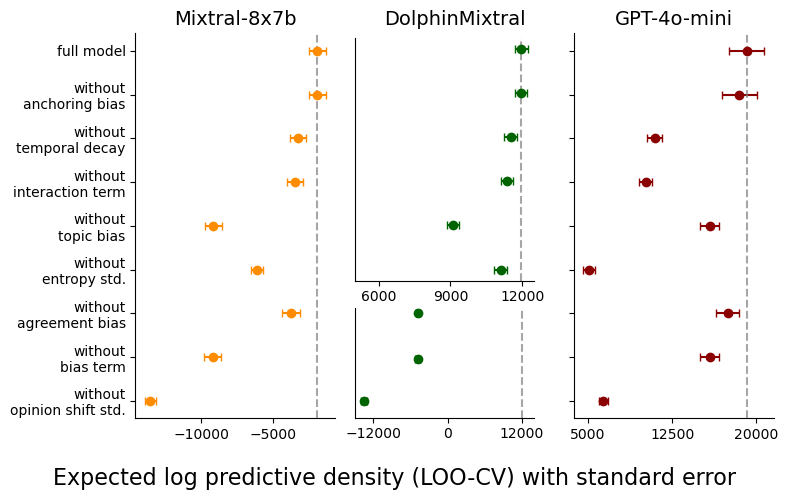

In [ ]:
# --- 1.  Tag and stack the three comparisons ---------------------------------
dfs = [all_dfs[0].copy(), all_dfs[1].copy(), all_dfs[2].copy()]          
for i, df in enumerate(dfs, 1):
    df['comparison'] = f'comp{i}'                  # identify each run
    df.rename(columns={'Unnamed: 0': 'model'}, inplace=True)

data = pd.concat(dfs, ignore_index=True)

# --- 2.  Order models by average performance (higher elpd_loo is better) ------
order = (data.groupby('model')['elpd_loo']
              .mean()
              .sort_values(ascending=False)
              .index)
pos = {m: i for i, m in enumerate(order)}          # y-axis positions

# --- 3.  Prepare subplots -----------------------------------------------------
n_comp = data['comparison'].nunique()
fig, axes = plt.subplots(1, n_comp, figsize=(8,5))

# --- 4.  Plot each comparison separately -------------------------------------
colors = ['darkorange', 'darkgreen', 'darkred']  
model_names = ['Mixtral-8x7b', 'DolphinMixtral', 'GPT-4o-mini']
comp_names = ['full model', 'without\nanchoring bias', 'without\ntemporal decay', 'without\ninteraction term', 'without\ntopic bias', 'without\nentropy std.', 'without\nagreement bias', 
               'without\nbias term', 'without\n' + "opinion shift std."]

for i, (ax, (comp, sub), color) in enumerate(zip(axes, data.groupby('comparison', sort=False), colors)):
    y = sub['model'].map(pos)

    if i != 1:  # Skip the inset for the second comparison
        ax.errorbar(sub['elpd_loo'], y, xerr=sub['se'], fmt='o', capsize=3, color=color)
        best_elp = sub['elpd_loo'].max()
        ax.axvline(best_elp, linestyle='--', color='grey', alpha=0.7)
        ax.spines[["top", "right"]].set_visible(False)

    if i==1:
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes


        axins = inset_axes(axes[1], width="60%", height="50%", loc="upper left", bbox_to_anchor=(-0.14, -0.2, 1.5, 1.26),
                            bbox_transform=axes[1].transAxes, borderpad=2)
        
        axins.errorbar(sub['elpd_loo'][:6], y[:6], xerr=sub['se'][:6], fmt='o', capsize=3, color=color)
        best_elp = sub['elpd_loo'].max()
        axins.axvline(best_elp, linestyle='--', color='grey', alpha=0.7)
        axins.set_xlim(5000, 12500)
        axins.invert_yaxis()
        axins.spines[["top", "right"]].set_visible(False)
        axins.set_yticks([])
        axins.set_xticks([6000, 9000, 12000])

        axins_2 = inset_axes(axes[1], width="60%", height="50%", loc="upper left", bbox_to_anchor=(-0.14, -0.211, 1.5, 0.57),
                            bbox_transform=axes[1].transAxes, borderpad=2)
        axins_2.errorbar(sub['elpd_loo'][6:], [5.65,6.9,8.05], xerr=sub['se'][6:], fmt='o', capsize=3, color=color)
        best_elp = sub['elpd_loo'].max()
        axins_2.axvline(best_elp, linestyle='--', color='grey', alpha=0.7)
        axins_2.set_xlim(-15000, 14000)
        axins_2.set_ylim(5.5,8.5)
        axins_2.invert_yaxis()
        axins_2.spines[["top", "right"]].set_visible(False)
        axins_2.set_yticks([])
        axins_2.set_xticks([-12000,0,12000])

    ax.set_title(model_names[i], fontsize=14)

axes[1].spines[["top", "right", "left", "bottom"]].set_visible(False)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_yticklabels([])

# --- 5.  Shared y-axis and final touches --------------------------------------
axes[0].set_yticks(range(len(order)))
axes[0].set_yticklabels(comp_names)
axes[0].invert_yaxis()
axes[2].invert_yaxis()
axes[2].set_yticklabels([])
axes[2].set_xticks([5000, 12500 ,20000])

fig.supxlabel('Expected log predictive density (LOO-CV) with standard error', fontsize=16)
fig.tight_layout()

plt.savefig("../../plots/figure_6.png", dpi=400, bbox_inches='tight')
plt.show()